In [377]:
"""
We are going to implement from scratch, with some help from
numpy, a Perceptron, ADALINE, and Logistic Regression Model.
We will be using the iris dataset to train and test our models.
"""
from math import exp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

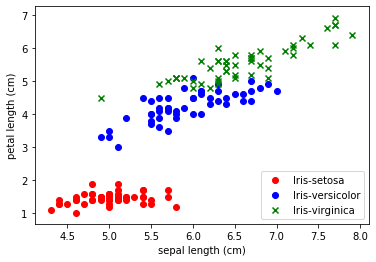

In [378]:
"""
Before we get into defining our models, we will explore the iris dataset and 
figure out what features we should use for classification
"""
iris = pd.read_csv('iris.data', header=None, 
                   names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])

## Let's see if we have linear separability with sepal length and petal length
plt.scatter(iris.loc[0:49, 'sepal_length'], iris.loc[0:49, 'petal_length'], c='r', label="Iris-setosa")
plt.scatter(iris.loc[50:99, 'sepal_length'], iris.loc[50:99, 'petal_length'], c='b', label="Iris-versicolor")
plt.scatter(iris.loc[100:, 'sepal_length'], iris.loc[100:, 'petal_length'], c='g', marker='x', label="Iris-virginica")
plt.xlabel('sepal length (cm)')
plt.ylabel('petal length (cm)')
plt.legend(loc='lower right')

plt.show()

In [379]:
"""
From the scatter plot shown above, we can see that there is clear linear separability
between iris-setosa and either of the other two species, however the line is blurred between 
iris-versicolor and iris-virginica. Our from-scratch models will use binary classification to 
distinguish between setosa and versicolor samples.
"""
features = np.asarray(list(zip(iris.loc[0:99, 'sepal_length'], iris.loc[0:99, 'petal_length'])))
targets = np.where(iris.loc[0:99, 'species'] == 'Iris-setosa', 1, -1)

In [380]:
"""
Now that we have our training data and targets, we will segment them into training and 
testing subsets using the sklearn train_test_split function, with 30% of the data being used
to test.
"""
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, stratify=targets, test_size=0.3)

In [381]:
"""
First up to bat is the Perceptron. This is a very basic linear classification model
and the first to draw inspiration from human neurons. The concept is very simple: Given 
a dataset with linearly separable features, it will compute a net sum using some weights
that we will try and optimize. If the net sum is over some threshold, we have a positive output value,
else we have a negative output value. This is based on the unit step function.
"""
class Perceptron(object):
    """
    We initialize our model with a learning rate (affects how much we incremement our weights by,
    a random_state that we will use when generating our initial weights, and the number of epochs our model
    will run through during training. We give them default values for convenience.
    """
    def __init__(self, learning_rate=0.01, random_state=1, epochs=50):
        self.learning_rate=0.01
        self.random_state=random_state
        self.epochs=epochs
        
    """
    This method will fit our model to the given training dataset.
    --------------
    Parameters
    
    features: np.ndarray: Each row should be an array of features for the training sample
    targets: np.ndarray, array-like: Known class labels for each training sample.
    
    ----------------
    Output
    
    A trained model with weights adjusted according to data set
    
    ---------------
    """
    def fit(self, features, targets):
        
        ## In order for calculations later on to be smoother, we insert a column of 1's to the training dataset
        features = np.insert(features, 0, 1, axis=1)
        
        ## Let us define some initial weights. We will draw from the normal distribution.
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=1.0, size=features[0].shape[0])
        
        ## We will run over the training samples {epochs} number of times
        for _ in range(self.epochs):
            for feature_vector, target in zip(features, targets):
                output = self.predict(feature_vector)
                error = target - output
                
                ## Update the weights based on error
                self.w_ += self.learning_rate * error * feature_vector
                
        ## After running through specified epochs and adjusting weights, return trained model
        return self
        
    ## Calculates the net sum for a given feature vector by multiplying weights with corresponding feature values
    def net_sum(self, feature_vector):
        return (self.w_.T.dot(feature_vector))
    
    ## Threshold function that predicts label based on net sum of features.
    def predict(self, feature_vector):
        net_sum = self.net_sum(feature_vector)
        return np.where(net_sum >= 0.0, 1, -1)
    
    ## Will return the accuracy of model as a decimal
    def test(self, test_features, test_targets):
        outputs = []
        test_features = np.insert(test_features, 0, 1, axis=1)
        
        for feature_vector in test_features:
            outputs.append(self.predict(feature_vector))
        
        errors = 0
        for i, output in enumerate(outputs):
            if output != test_targets[i]:
                errors += 1
        
        return 1.0 - (errors / len(test_targets))
        

In [382]:
"""
Here, we will train our perceptron, and test its performance
"""
ppn = Perceptron()
ppn = ppn.fit(features_train, targets_train)
ppn_accuracy = ppn.test(features_test, targets_test)

print(f"Perceptron made predictions on test data with an accuracy of {ppn_accuracy * 100}%")

Perceptron made predictions on test data with an accuracy of 100.0%


In [383]:
"""
The next linear classification model we will implement is the Adaptive Linear Neuron, 
or ADALINE. This model will use gradient descent to optimize its cost function, ie. minimize
the sum squared error. For it to be effective, we will first scale our test and train features 
using sklearn's StandardScaler
"""
sc = StandardScaler()
sc = sc.fit(features_train)

features_train_scaled = sc.transform(features_train)
features_test_scaled = sc.transform(features_test)

In [384]:
"""
Now, we implement our ADALINE model. It uses a simple linear activation function, phi(z) = z.
Our threshold function remains more or less the same: T(x) = 1 if phi(z) >= 0.0, -1 otherwise.
Or, T(x) = 1 if z >= 0.0, -1 otherwise. Weights are optimized using gradient descent.
"""
class Adaline(object):
    def __init__(self, learning_rate=0.01, random_seed=1, epochs=50):
        self.learning_rate = learning_rate,
        self.random_seed = random_seed,
        self.epochs = epochs
        
    def fit(self, features, targets):
        
        # Add 1 to each feature vector so that x_0 = 1 for multiplication with bias unit
        features = np.insert(features, 0, 1, axis=1)
        
        ##Initialize weights using the normal distribution
        rgen = np.random.RandomState(self.random_seed)
        self.w_ = rgen.normal(loc=0.0, scale=1, size=features[0].shape[0])
        
        for _ in range(self.epochs):
            errors = []
            for feature_vector, target in zip(features, targets):
                output = self.predict(feature_vector)
                errors.append(target - output)
            
            ##Weight update based on all samples for gradient descent
            update = self.learning_rate * (np.asarray(errors).dot(features))
            self.w_ += update
            
        return self
        
    def net_sum(self, feature_vector):
        return (self.w_.T.dot(feature_vector))
    
    def activate(self, net_sum):
        return net_sum
    
    def predict(self, feature_vector):
        net_sum = self.net_sum(feature_vector)
        output = self.activate(net_sum)    ## This has no effect as activation function is linear in this case
        
        if output >= 0.0:
            return 1
        else:
            return -1
    
    def get_cost(self, errors):
        errors = np.asarray(errors)
        return (errors ** 2).sum()
    
    def test(self, test_features, test_targets):
        outputs = []
        test_features = np.insert(test_features, 0, 1, axis=1)
        
        for feature_vector in test_features:
            outputs.append(self.predict(feature_vector))
            
        errors = 0
        for i, prediction in enumerate(outputs):
            if (prediction != test_targets[i]):
                errors += 1
                
        return 1 - (errors / len(test_targets))

In [385]:
"""
We fit our Adaline implementation to the iris training data (after scaling)
and test its effectiveness
"""
ad = Adaline()
ad = ad.fit(features_train_scaled, targets_train)
ad_accuracy = ad.test(features_test_scaled, targets_test)

print(f"Adaline made predictions on test data with an accuracy of {ad_accuracy * 100}%")

Adaline made predictions on test data with an accuracy of 100.0%


In [386]:
"""
Our final implementation of a linear learning model will be that of logistic regression
which uses the sigmoid activation function. Optimization is achieved through gradient descent.
Despite its name suggesting this is a Regression model, it is still a binary classifier.
"""
class LogisticRegression():
    def __init__(self, learning_rate=0.01, random_seed=1, epochs=50):
        self.learning_rate = learning_rate
        self.random_seed = random_seed
        self.epochs = epochs
    
    def fit(self, features, targets):
        ## Adding a column of 1's to represent x_0 and make calculations involving bias unit easier
        features = np.insert(features, 0, 1, axis=1)
        
        ## Generating initial weights using the normal distribution
        rgen = np.random.RandomState(self.random_seed)
        self.w_ = rgen.normal(loc=0.0, scale=1, size=features[0].shape[0])
        
        for _ in range(self.epochs):
            errors = []
            for feature_vector, target in zip(features, targets):
                output = self.predict(feature_vector)
                errors.append(target - output)
            
            ## Update of weights very similar to method used in Adaline
            update = self.learning_rate * (np.asarray(errors).dot(features))
            self.w_ += update
        
        return self
            
    def net_sum(self, feature_vector):
        return (self.w_.T.dot(feature_vector))
    
    def activate(self, net_sum):
        return 1 / (1 + exp(-1 * net_sum))    ## Value given by sigmoid function
    
    def predict(self, feature_vector):
        net_sum = self.net_sum(feature_vector)
        output = self.activate(net_sum)
        
        if output >= 0.5:
            return 1
        else:
            return 0
        
    def test(self, features_test, targets_test):
        features_test = np.insert(features_test, 0, 1, axis=1)
        outputs = []
        
        for feature_vector in features_test:
            outputs.append(self.predict(feature_vector))
            
        errors = 0
        for i, prediction in enumerate(outputs):
            if prediction != targets_test[i]:
                errors += 1
                
        return 1 - (errors / len(targets_test))

In [387]:
"""
The activation function used by our Logistic Regression model has a 
range (0, 1), and so we need to adjust targets accordingly.
"""
lgr_targets_train = np.where(targets_train == -1, 0, 1)
lgr_targets_test = np.where(targets_test == -1, 0, 1)

In [388]:
"""
Training and testing our Logistic Regression model
"""

lgr = LogisticRegression()
lgr = lgr.fit(features_train_scaled, lgr_targets_train)
lgr_accuracy = lgr.test(features_test_scaled, lgr_targets_test)

print(f"Logistic Regression model made predictions on test data with an accuracy of {lgr_accuracy * 100}%")

Logistic Regression model made predictions on test data with an accuracy of 100.0%


In [389]:
"""
We have verified that our tests work for the iris dataset. As an additional measure
we will test all of our models on another classic dataset: the BUPA liver disorders dataset.
The models are not expected to generate accurate predictions as none of the classes are linearly
separable from the others!
"""
data_url = 'ftp://ftp.ics.uci.edu/pub/machine-learning-databases/liver-disorders/bupa.data'
bupa = pd.read_csv(data_url, header=None)
bupa.head()

,0,1,2,3,4,5,6
0,85,92,45,27,31,0.0,1
1,85,64,59,32,23,0.0,2
2,86,54,33,16,54,0.0,2
3,91,78,34,24,36,0.0,2
4,87,70,12,28,10,0.0,2


In [390]:
## Separating features and targets.
features = bupa.iloc[:, 0:6].values
targets = np.where(bupa[6] == 2, -1, 1)

In [391]:
## Train, test split with 20% of the data being used to test our models
features_train, features_test, targets_train, targets_test = train_test_split(features, targets, stratify=targets,
                                                                             test_size = 0.2)

## Special target data for logistic regression
lgr_targets_train = np.where(targets_train == -1, 0, 1)
lgr_targets_test = np.where(targets_test == -1, 0, 1)

In [392]:
## Scaling features for faster gradient descent in Adaline and Logistic Regression
sc = StandardScaler()
sc = sc.fit(features_train)
features_train_scaled = sc.transform(features_train)
features_test_scaled = sc.transform(features_test)

In [393]:
## Testing our perceptron model with the new data
ppn = Perceptron()
ppn = ppn.fit(features_train_scaled, targets_train)
ppn_accuracy = ppn.test(features_test_scaled, targets_test)

print(f"Perceptron made predictions on test data with an accuracy of {ppn_accuracy * 100}%")

Perceptron made predictions on test data with an accuracy of 68.11594202898551%


In [394]:
## Testing our adaline model with the new data
ad = Adaline()
ad = ad.fit(features_train_scaled, targets_train)
ad_accuracy = ad.test(features_test_scaled, targets_test)

print(f"Adaline made predictions on test data with an accuracy of {ad_accuracy * 100}%")

Adaline made predictions on test data with an accuracy of 55.072463768115945%


In [395]:
## Testing our logical regression model with the new data
lgr = LogisticRegression()
lgr = lgr.fit(features_train_scaled, lgr_targets_train)
lgr_accuracy = lgr.test(features_test_scaled, lgr_targets_test)

print(f"Logistic Regression model made predictions on test data with an accuracy of {lgr_accuracy * 100}%")

Logistic Regression model made predictions on test data with an accuracy of 56.52173913043479%
